# Wstęp do uczenia maszynowego - praca domowa 3
## Aleksander Malinowski | Damian Skowroński
___
Będziemy używamć zbioru danych [Company Bankrupcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction?resource=download), który zawiera dane dotyczące bankructwa z _Taiwan Economic Journal_ z lat 1999-2009.

Używaliśmy _Google Colab_, więc ramkę danych wczytaliśmy z naszego _Google Drive_.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")

drive.mount('/content/drive')
df = pd.read_csv('./drive/MyDrive/data.csv')
df.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float

Z info dowiedzieliśmy się, że ma brakujących wartości, a także, że wszystkie zmienne są typu float oprócz _Liability-Assets Flag_, _Net Income Flag_, a także zmiennej celu _Bankrupt?_, które są typu int. 

Przed sprawdzeniem ich najpierw zobaczymy, czy może niektóre zmienne mimo bycia floatem, mają niewielką rożnorodność wartości.

In [2]:
for col in df:
  if len(df[col].unique()) < 100:
    print(df[col].unique(), col)


[1 0] Bankrupt?
[0 1]  Liability-Assets Flag
[1]  Net Income Flag


Okazuje się, że tylko kolumny typu int mają niewiele unikalnych wartości.


Sprawdzimy, czy jest sens zostawiać zmienne  _Liability-Assets Flag_ i _Net Income Flag_.

In [3]:
df[' Liability-Assets Flag'].value_counts()

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

In [4]:
df[' Net Income Flag'].value_counts()

1    6819
Name:  Net Income Flag, dtype: int64

Jak widać te zmienne przyjmują jedną wartość dla prawie każdej informacji więc raczej nie są potrzebne, więc po prostu się ich pozbędziemy.

In [5]:
df.drop(columns = [' Liability-Assets Flag',' Net Income Flag'], inplace = True)

Dzielimy teraz zbiór na treningowy i walidacyjny.

In [6]:
from sklearn.model_selection import train_test_split
df_train,df_val = train_test_split(df,test_size=0.3, random_state=420, stratify=df['Bankrupt?'])

Zapisujemy zbiór walidacyjny do csv i więcej z nim nic nie robimy.

In [7]:
df_val.to_csv('df_val.csv')

### Preprocessing 
Na początku zajmiemy się wartościami odstającymi w taki sposób, że jeśli wartości są większe niż $0.975$ kwantyl, lub mniejsze niż $0.025$ to je na wartości tych kwantyli. Możemy to zrobić na całej ramce oprócz na zmiennej celu, bo wszystkie zmienne są typu float. 

In [8]:
def outliers_to_quantiles(df):
  up_quantiles = df.quantile(0.975,axis=0)
  down_quantiles = df.quantile(0.025,axis=0)
  outliers_low = (df < down_quantiles)
  outliers_high = (df > up_quantiles)
  df_train = df.where(~outliers_low, down_quantiles, axis=1)
  df_train = df.where(~outliers_high, up_quantiles, axis=1)
  return df

df_train = outliers_to_quantiles(df_train)

Teraz zamienimy kierunek korelacji, czyli chcemy aby każda zmiennna miała dodatnią korelację ze zmienną celu.

In [9]:
def make_corr_positive(df):
  corrs = df.corrwith(df_train['Bankrupt?'])
  neg_corrs = np.where(corrs < 0)
  # Mamy zmienne, które mają negatywną korelację ze zmienną celu. Teraz po prostu zamienimy znak dla wartości całej zmiennej co sprawi, że te korelacje będą dodatnie.
  df.iloc[:,neg_corrs[0].tolist()] = -df.iloc[:,neg_corrs[0].tolist()]
  return df

df_train = make_corr_positive(df_train)

In [10]:
np.sum(df_train.corrwith(df_train['Bankrupt?']) > 0)

94

Wykonujemy teraz normalizację min-max dla zbioru treningowego, następnie dzielimy zbiór na zbiory treningowe i testowe.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


def normalize_and_split(df):
  X = df.drop(columns = ['Bankrupt?'])  #zmienne opisujące, które będą normalizowane
  Y  = df['Bankrupt?']                  #zmienna celu
  X = MinMaxScaler().fit_transform(X)
  return train_test_split(X, Y, test_size=0.3, random_state=420, stratify=Y)

X_train, X_test, y_train, y_test = normalize_and_split(df_train)

### Modele
Po przeprowadzonym preprocessingu, zajmiemy się klasyfikacją. Na początku zobaczymy jak spisuje się kilka rodzajów modeli na naszym zbiorze.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

from scikitplot.estimators import plot_learning_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score, plot_confusion_matrix
from sklearn.model_selection import cross_val_score


models = {
    'LGR': LogisticRegression(solver = 'lbfgs', random_state=420, verbose=0),
    'DTC': DecisionTreeClassifier(random_state=420),
    'RFC': RandomForestClassifier(random_state=420),
    'ETC': ExtraTreesClassifier(random_state=420),
    'XGB': xgb.XGBClassifier(random_state=420),
    'LGBM': lgb.LGBMClassifier(random_state=420),
    'CTB': ctb.CatBoostClassifier(verbose=0),
}


def train_model(model, X, y):
    model.fit(X, y)
    return model

def predict_model(model, X):
    y_pred = model.predict(X)
    return y_pred

def score_model(y_test, y_pred, scoring):
    score = scoring(y_test, y_pred, average='micro')
    return score

def train_and_predict(model, X, y, scoring):
    scores = cross_val_score(model, X, y, cv = 3, scoring = scoring)
    return np.mean(scores), np.std(scores)

def run_model(model, X_train,X_test,y_train,y_test):
    model_name = model[0]
    model = model[1]
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,average='micro')
    precision = precision_score(y_test, y_pred,average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    auc = roc_auc_score(y_test,y_pred)
    
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print('auc', auc)
    print(classification_report(y_test, y_pred))
    
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    if model_name != 'CTB':
      plot_learning_curve(model, X_test, y_test, scoring='roc_auc');    
      plt.show()

LGR
[0 0 0 ... 0 0 0] 

accuracy:  0.9699720670391061
recall:  0.9699720670391061
precision:  0.9699720670391061
f1_micro:  0.9699720670391061
auc 0.5536263253654559
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1386
           1       0.71      0.11      0.19        46

    accuracy                           0.97      1432
   macro avg       0.84      0.55      0.59      1432
weighted avg       0.96      0.97      0.96      1432



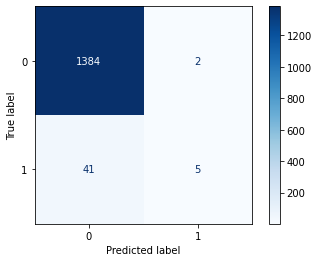

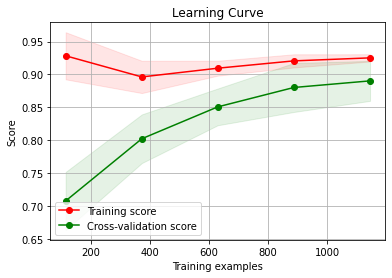

DTC
[0 0 0 ... 1 0 0] 

accuracy:  0.9574022346368715
recall:  0.9574022346368715
precision:  0.9574022346368715
f1_micro:  0.9574022346368715
auc 0.620694522868436
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1386
           1       0.31      0.26      0.28        46

    accuracy                           0.96      1432
   macro avg       0.64      0.62      0.63      1432
weighted avg       0.95      0.96      0.96      1432



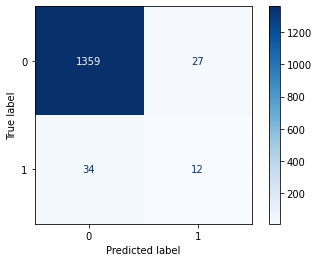

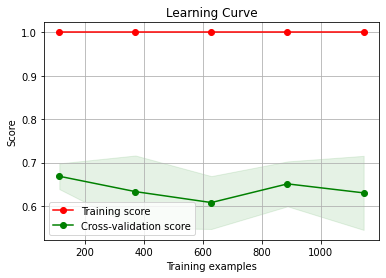

RFC
[0 0 0 ... 0 0 0] 

accuracy:  0.973463687150838
recall:  0.973463687150838
precision:  0.973463687150838
f1_micro:  0.973463687150838
auc 0.5974653365957714
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.90      0.20      0.32        46

    accuracy                           0.97      1432
   macro avg       0.94      0.60      0.65      1432
weighted avg       0.97      0.97      0.97      1432



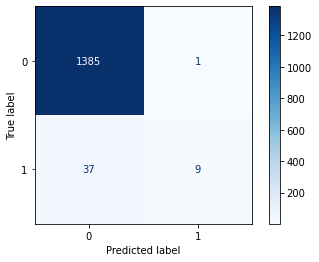

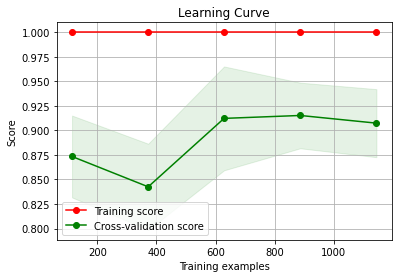

ETC
[0 0 0 ... 0 0 0] 

accuracy:  0.9706703910614525
recall:  0.9706703910614525
precision:  0.9706703910614525
f1_micro:  0.9706703910614526
auc 0.5539870757262062
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.83      0.11      0.19        46

    accuracy                           0.97      1432
   macro avg       0.90      0.55      0.59      1432
weighted avg       0.97      0.97      0.96      1432



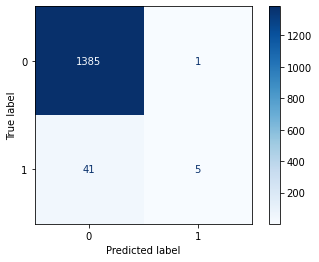

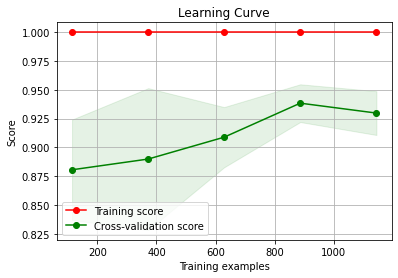

XGB
[0 0 0 ... 0 0 0] 

accuracy:  0.9706703910614525
recall:  0.9706703910614525
precision:  0.9706703910614525
f1_micro:  0.9706703910614526
auc 0.5960223351527699
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.64      0.20      0.30        46

    accuracy                           0.97      1432
   macro avg       0.81      0.60      0.64      1432
weighted avg       0.96      0.97      0.96      1432



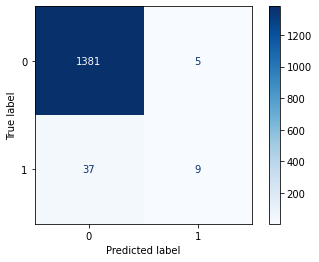

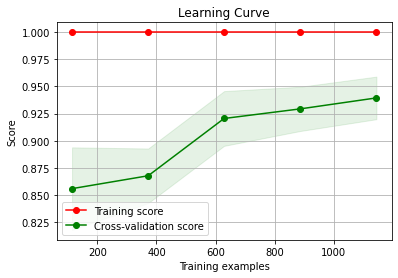

LGBM
[0 0 0 ... 0 0 0] 

accuracy:  0.9720670391061452
recall:  0.9720670391061452
precision:  0.9720670391061452
f1_micro:  0.9720670391061452
auc 0.5862350210176296
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.80      0.17      0.29        46

    accuracy                           0.97      1432
   macro avg       0.89      0.59      0.64      1432
weighted avg       0.97      0.97      0.96      1432



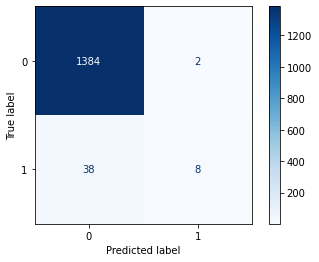

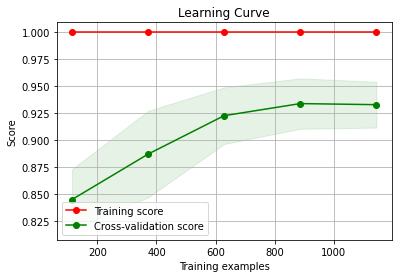

CTB
[0 0 0 ... 0 0 0] 

accuracy:  0.9713687150837989
recall:  0.9713687150837989
precision:  0.9713687150837989
f1_micro:  0.9713687150837989
auc 0.5858742706568792
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1386
           1       0.73      0.17      0.28        46

    accuracy                           0.97      1432
   macro avg       0.85      0.59      0.63      1432
weighted avg       0.97      0.97      0.96      1432



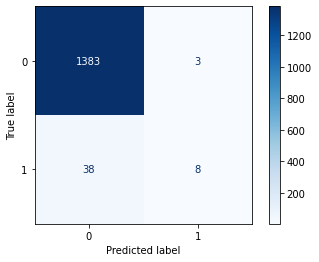

In [17]:
for model in models.items():
    print(model[0])
    run_model(model, X_train,X_test,y_train,y_test)

Jak widać każdy z modeli ma całkiem wysokie wyniki we wszystkim oprócz auc. Zapewne jest tak dlatego, że bardzo trudno mu jest zgadnąć kiedy zmienna celu ma wartość "1", bo w zbiorze jest ich bardzo mało.

W takim razie spróbujemy dodać mu więcej obserwacji, które mają wartość "1" w zmiennej celu, po prostu kopiująć je i zobaczymy co się wydarzy.

In [18]:
bankrupt_rows = X_train[y_train == 1]
n=30
X_train_copied = X_train
y_train_copied = y_train
for i in range(n):
  X_train_copied = np.concatenate((X_train_copied,bankrupt_rows))

y_train_copied = np.concatenate((y_train_copied,np.ones((bankrupt_rows.shape[0]*n,))))

LGR
[0. 0. 0. ... 1. 1. 0.] 

accuracy:  0.848463687150838
recall:  0.848463687150838
precision:  0.848463687150838
f1_micro:  0.848463687150838
auc 0.8586642825773259
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      1386
           1       0.16      0.87      0.27        46

    accuracy                           0.85      1432
   macro avg       0.58      0.86      0.59      1432
weighted avg       0.97      0.85      0.89      1432



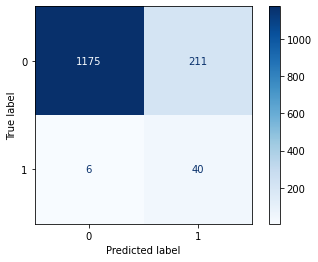

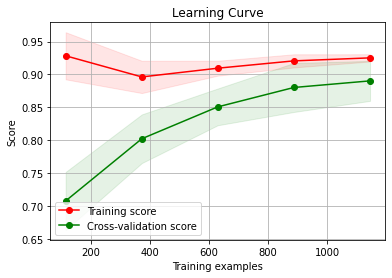

DTC
[0. 1. 0. ... 1. 0. 0.] 

accuracy:  0.9511173184357542
recall:  0.9511173184357542
precision:  0.9511173184357542
f1_micro:  0.9511173184357542
auc 0.5964301399084009
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1386
           1       0.23      0.22      0.22        46

    accuracy                           0.95      1432
   macro avg       0.60      0.60      0.60      1432
weighted avg       0.95      0.95      0.95      1432



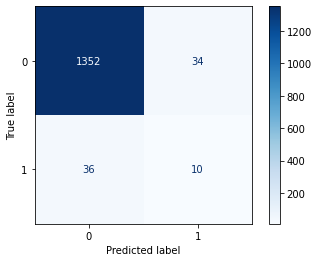

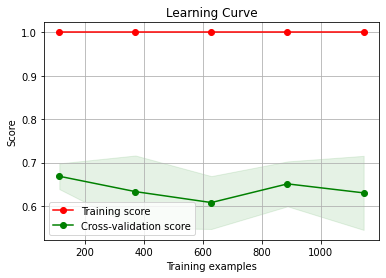

RFC
[0. 0. 0. ... 0. 0. 0.] 

accuracy:  0.9713687150837989
recall:  0.9713687150837989
precision:  0.9713687150837989
f1_micro:  0.9713687150837989
auc 0.6384183449400841
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1386
           1       0.62      0.28      0.39        46

    accuracy                           0.97      1432
   macro avg       0.80      0.64      0.69      1432
weighted avg       0.97      0.97      0.97      1432



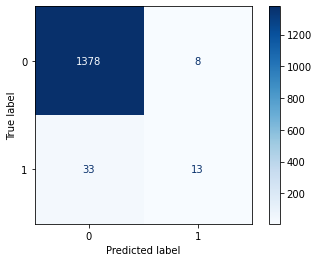

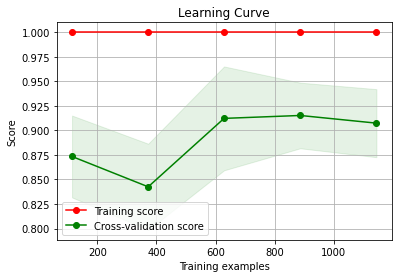

ETC
[0. 0. 0. ... 0. 0. 0.] 

accuracy:  0.9685754189944135
recall:  0.9685754189944135
precision:  0.9685754189944135
f1_micro:  0.9685754189944135
auc 0.5108695652173914
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1386
           1       1.00      0.02      0.04        46

    accuracy                           0.97      1432
   macro avg       0.98      0.51      0.51      1432
weighted avg       0.97      0.97      0.95      1432



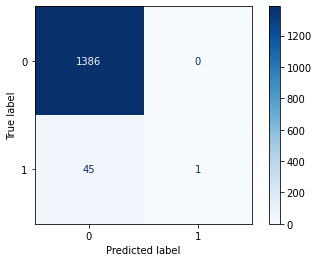

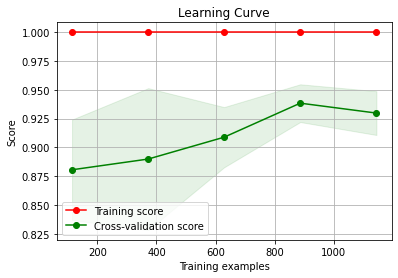

XGB
[0. 0. 0. ... 1. 0. 0.] 

accuracy:  0.9343575418994413
recall:  0.9343575418994413
precision:  0.9343575418994413
f1_micro:  0.9343575418994413
auc 0.7559131689566471
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1386
           1       0.26      0.57      0.36        46

    accuracy                           0.93      1432
   macro avg       0.62      0.76      0.66      1432
weighted avg       0.96      0.93      0.95      1432



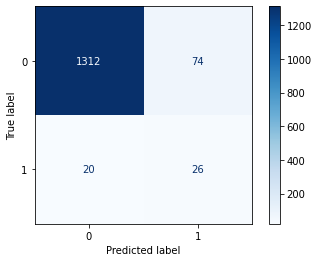

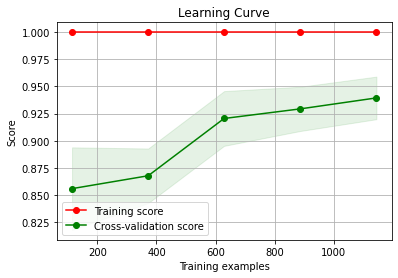

LGBM
[0. 0. 0. ... 0. 0. 0.] 

accuracy:  0.9706703910614525
recall:  0.9706703910614525
precision:  0.9706703910614525
f1_micro:  0.9706703910614526
auc 0.6380575945793336
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1386
           1       0.59      0.28      0.38        46

    accuracy                           0.97      1432
   macro avg       0.78      0.64      0.68      1432
weighted avg       0.96      0.97      0.97      1432



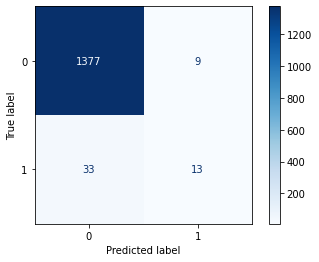

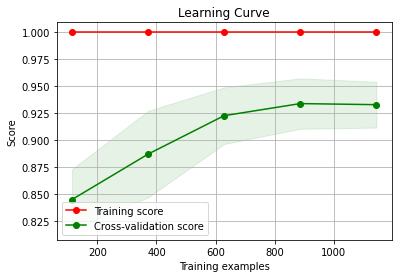

CTB
[0. 0. 0. ... 0. 0. 0.] 

accuracy:  0.9636871508379888
recall:  0.9636871508379888
precision:  0.9636871508379888
f1_micro:  0.9636871508379888
auc 0.644958905828471
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1386
           1       0.41      0.30      0.35        46

    accuracy                           0.96      1432
   macro avg       0.69      0.64      0.67      1432
weighted avg       0.96      0.96      0.96      1432



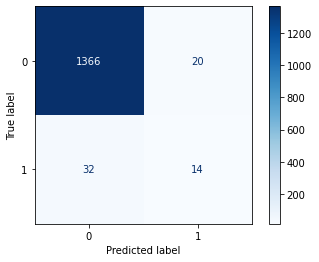

In [19]:
for model in models.items():
    print(model[0])
    run_model(model, X_train_copied,X_test,y_train_copied,y_test)

Wychodzi na to, że zwykłe kopiowanie w celu dostarczenia więcej potrzebnych obserwacji bardzo pomaga niektórym modelom, a na niektóre nie ma wcale wpływu.

Biorąc pod uwagę dotychczasowe testy, jako 3 modele, którymi się będziemy dalej zajmować będą:

* DecisionTreeClassifier używający pierwotnego zbioru treningowego
* LogisticRegression używający zbioru z kopiami
* XGBoost używający zbioru z kopiami

Będziemy teraz chcieli znaleźć kolumny, które mają znaczenie dla naszych modeli, w tym celu musimy przywrócić nazwy kolumn dla naszych zbiorów treningowych i testowego.

In [20]:
X_train = pd.DataFrame(X_train, columns = df_train.drop(columns = ['Bankrupt?']).columns)
X_test = pd.DataFrame(X_test, columns = df_train.drop(columns = ['Bankrupt?']).columns)
X_train_copied = pd.DataFrame(X_train_copied, columns = df_train.drop(columns = ['Bankrupt?']).columns)

Następnie znajdujemy te zmienne dla naszych 3 wybranych wcześniej modeli.

**Przed walidacją robiliśmy to w ten sposób, że braliśmy kilka najlepszych zmiennych, a reszte wyrzucaliśmy. Okazało się jednak, że nie jest to najlepsze podejście i zamiast tego spróbujemy wyrzucić te zmienne, które są najgorsze dla każdego modelu, co powinno lepiej zapobiec sytuacji, że wyrzucimy zmienną, która dla któregoś modelu jest dobra.**

In [23]:
from eli5 import explain_weights_df
from eli5.formatters.as_dataframe import explain_weights_df
from eli5.sklearn import PermutationImportance


def show_importance(model,X_train,y_train):
  model.fit(X_train,y_train)
  imp = PermutationImportance(model, random_state = 420).fit(X_train, y_train)
  return explain_weights_df(imp, feature_names = X_train.columns.values)

dtl_importance = show_importance(DecisionTreeClassifier(random_state=420),X_train,y_train)
xgb_importance = show_importance(xgb.XGBClassifier(random_state=420),X_train_copied,y_train_copied)
lr_importance = show_importance(LogisticRegression(random_state=420),X_train_copied,y_train_copied)

**Z tego mamy ramki danych, w których zmienne są posortowane względem ich wagi, i weźmiemy teraz. Wyznaczymy potrzebne zmienne poprzez usunięcie tych, które nie są w top 20 żadnego z modeli.**

In [24]:
dtl_bad = dtl_importance.loc[20:,"feature"].values
xgb_bad = xgb_importance.loc[20:,"feature"].values
lr_bad = lr_importance.loc[20:,"feature"].values

In [25]:
dtl_and_xgb_bad = dtl_bad[np.where(np.in1d(dtl_bad,xgb_bad))[0]]
dtl_and_lr_bad = dtl_bad[np.where(np.in1d(dtl_bad,lr_bad))[0]]
xgb_and_lr_bad = xgb_bad[np.where(np.in1d(xgb_bad,lr_bad))[0]]

In [26]:
join_bad = dtl_and_xgb_bad[np.where(np.in1d(dtl_and_xgb_bad,dtl_and_lr_bad))[0]]
all_bad = join_bad[np.where(np.in1d(join_bad,xgb_and_lr_bad))[0]]

Teraz zostawiamy w zbiorach danych, tylko te zmienne, które okazały się ważne.

In [27]:
important_feats = X_train.columns[np.where(np.logical_not(np.in1d(X_train.columns,all_bad)))[0]]

X_train = X_train[important_feats]
X_train_copied = X_train_copied[important_feats]
X_test = X_test[important_feats]

I testujemy modele na odpowiadających im zbiorach.

In [28]:
def run_model_best(model, X_train,X_test,y_train,y_test):
    model = train_model(model, X_train, y_train)
    y_pred = predict_model(model, X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred,average='micro')
    precision = precision_score(y_test, y_pred,average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    auc = roc_auc_score(y_test,y_pred)
    
    print(y_pred,'\n')
    print('accuracy: ', accuracy)
    print('recall: ',recall)
    print('precision: ', precision)
    print('f1_micro: ', f1)
    print('auc', auc)
    print(classification_report(y_test, y_pred))
    
    
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues');    
    plt.show()
    plot_learning_curve(model, X_test, y_test, scoring='roc_auc');    
    plt.show()

[0 0 0 ... 1 0 0] 

accuracy:  0.9553072625698324
recall:  0.9553072625698324
precision:  0.9553072625698324
f1_micro:  0.9553072625698324
auc 0.5985946420729029
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1386
           1       0.26      0.22      0.24        46

    accuracy                           0.96      1432
   macro avg       0.62      0.60      0.61      1432
weighted avg       0.95      0.96      0.95      1432



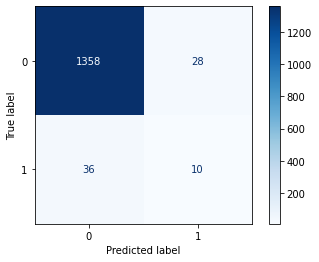

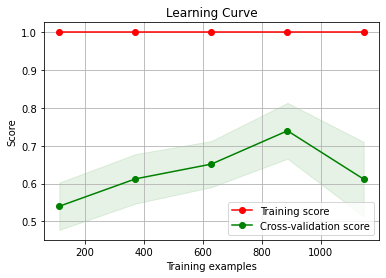

In [29]:
run_model_best(DecisionTreeClassifier(random_state=420),X_train,X_test,y_train,y_test)

[0. 0. 0. ... 1. 0. 0.] 

accuracy:  0.9371508379888268
recall:  0.9371508379888268
precision:  0.9371508379888268
f1_micro:  0.9371508379888268
auc 0.8099002446828534
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1386
           1       0.29      0.67      0.41        46

    accuracy                           0.94      1432
   macro avg       0.64      0.81      0.69      1432
weighted avg       0.97      0.94      0.95      1432



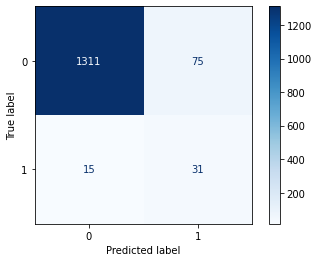

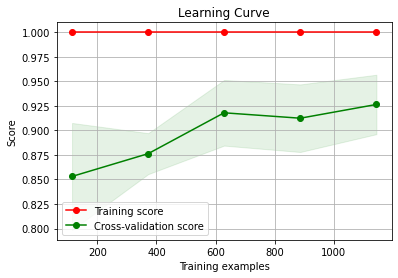

In [30]:
run_model_best(xgb.XGBClassifier(random_state=420),X_train_copied,X_test,y_train_copied,y_test)

[0. 0. 0. ... 1. 1. 0.] 

accuracy:  0.848463687150838
recall:  0.848463687150838
precision:  0.848463687150838
f1_micro:  0.848463687150838
auc 0.8796819122906079
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1386
           1       0.16      0.91      0.28        46

    accuracy                           0.85      1432
   macro avg       0.58      0.88      0.60      1432
weighted avg       0.97      0.85      0.89      1432



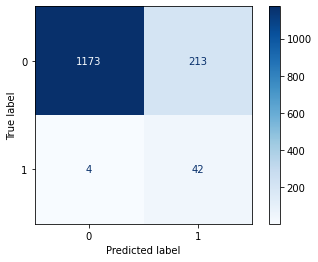

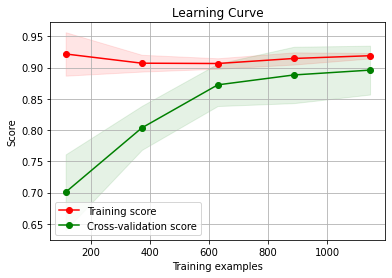

In [31]:
run_model_best(LogisticRegression(random_state=420),X_train_copied,X_test,y_train_copied,y_test)

**Dla DecisionTree niewiele się zmieniło, za to dla XGBoosta i LogisticRegression auc score wyszło lepsze**

### Hiperparametry
We wcześniej wybranych modelach dostosujemy teraz hiperparametry.



#### 1. DecistionTree

In [32]:
from sklearn.model_selection import GridSearchCV

model = DecisionTreeClassifier()
grid = GridSearchCV(model, param_grid={
    'criterion' : ["gini", "entropy"], 
    'max_features': ["auto","sqrt","log2"],
    'max_depth': [20,50,100,250,500,1000],
    "min_samples_split" : [2,3,4,5]
    }, n_jobs=-1, cv = 5,scoring="roc_auc")

grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [20, 50, 100, 250, 500, 1000],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='roc_auc')

In [33]:
grid.best_score_

0.6881229969931815

In [34]:
dtc = grid.best_estimator_

In [35]:
score_model(y_test, grid.best_estimator_.predict(X_test), roc_auc_score)

0.6229060794278185

#### 2. LogisticRegression

In [36]:
model = LogisticRegression()
grid = GridSearchCV(model, param_grid={
    'penalty': ['l2', 'l1', 'elasticnet'], 
    'C': [0.5,0.75,1,1.5,2],
    'max_iter': [50,100,250,500]
    }, n_jobs=-1, cv = 5,scoring="roc_auc")

grid.fit(X_train_copied,y_train_copied)



GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.5, 0.75, 1, 1.5, 2],
                         'max_iter': [50, 100, 250, 500],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='roc_auc')

In [37]:
grid.best_score_

0.9403148772488231

In [38]:
lr = grid.best_estimator_

In [39]:
score_model(y_test, grid.best_estimator_.predict(X_test), roc_auc_score)

0.8905514775079993

#### 3. XGBoost

In [40]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from functools import partial

def hyperopt_XGB():
    trials = Trials()
    
    space ={
        'max_depth': hp.quniform ('max_depth', 2, 8, 1),
        'learning_rate': hp.uniform ('learning_rate', 0.01, 0.5),
        'subsample': hp.uniform ('subsample', 0.8, 1.),
        'reg_lambda': hp.uniform ('reg_lambda', 0.7, 1.),
        'n_estimators': hp.quniform ('n_estimators', 10, 1000, 1),
        'random_state': 42,
    }
    
    best_params = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=60,
                trials=trials)

    print("The best params: ", best_params)
    return trials.best_trial

def objective(space):
    
    params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'random_state': int(space['random_state']),
    }
    
    model = xgb.XGBClassifier(**params)
    model = train_model(model, X_train_copied, y_train_copied)
    y_pred = predict_model(model, X_test)
    score = score_model(y_test, y_pred, roc_auc_score)
    
    return{'loss': -score, 'status': STATUS_OK }

hyperopt_XGB()

100%|██████████| 60/60 [04:10<00:00,  4.17s/it, best loss: -0.8327686805947675]
The best params:  {'learning_rate': 0.31699636451231966, 'max_depth': 4.0, 'n_estimators': 14.0, 'reg_lambda': 0.7531252454784829, 'subsample': 0.896130949785627}


{'book_time': datetime.datetime(2022, 4, 14, 11, 8, 57, 21000),
 'exp_key': None,
 'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'learning_rate': [37],
   'max_depth': [37],
   'n_estimators': [37],
   'reg_lambda': [37],
   'subsample': [37]},
  'tid': 37,
  'vals': {'learning_rate': [0.31699636451231966],
   'max_depth': [4.0],
   'n_estimators': [14.0],
   'reg_lambda': [0.7531252454784829],
   'subsample': [0.896130949785627]},
  'workdir': None},
 'owner': None,
 'refresh_time': datetime.datetime(2022, 4, 14, 11, 8, 57, 300000),
 'result': {'loss': -0.8327686805947675, 'status': 'ok'},
 'spec': None,
 'state': 2,
 'tid': 37,
 'version': 0}

In [41]:
best_params_XGB = {'learning_rate': 0.046954971099871984, 'max_depth': 3.0, 'n_estimators': 162, 'reg_lambda': 0.8329053651615159, 'subsample': 0.9996019513087633}


In [42]:
xgb = xgb.XGBClassifier(learning_rate = 0.046954971099871984, max_depth = 3, n_estimators = 162, reg_lambda = 0.8329053651615159, subsample = 0.9996019513087633)
xgb.fit(X_train_copied,y_train_copied)
y_pred = predict_model(xgb, X_test)
score_model(y_test, y_pred, roc_auc_score)

0.8269496204278813

### Wyniki
Otrzymaliśmy trzy modele z dostrojonymi parametrami. Teraz zobaczymy ich wyniki metryk: 
* roc_auc
* f1
* accuracy


In [43]:
models = {
    "DecisionTree":dtc,
    "LogisticRegression":lr,
    "XGBoost":xgb
          }
for model in models.items():
  print(model[0])
  print("roc_auc =",roc_auc_score(y_test, model[1].predict(X_test)))
  print("f1 =",f1_score(y_test, model[1].predict(X_test)))
  print("accuracy =",accuracy_score(y_test, model[1].predict(X_test)))
  print("")


DecisionTree
roc_auc = 0.6229060794278185
f1 = 0.23636363636363636
accuracy = 0.9413407821229051

LogisticRegression
roc_auc = 0.8905514775079993
f1 = 0.28476821192052976
accuracy = 0.8491620111731844

XGBoost
roc_auc = 0.8269496204278813
f1 = 0.39520958083832336
accuracy = 0.9294692737430168



Na podstawie wyników, wygląda na to, że najlepszym modelem okazał się XGBoost.

### Podsumowanie
* Sprawdziliśmy braki danych, typy zmiennych i ich unikalne wartości. 
* Zamieniliśmy outliery
* Zmieniliśmy korelację poszczególnych zmiennych z zmienną celu, tak aby były wszystkie dodatnie
* Wykonaliśmy normalizację min-max
* Poszukaliśmy dobrego modelu klasyfikującego, ale nie szło to najlepiej
* Wobec tego spróbowaliśmy dodać obserwacje o zmiennej celu równej 1
* Na nowym zbiorze danych przetestowaliśmy znowu modele klasyfikacyjne i okazało się, że niektóre sobie dużo lepiej radzą
* Zmniejszyliśmy ilość zmiennych
* Dostroiliśmy hiperparametry wybranych modeli